In [191]:
# Librerie base
import numpy as np
import pandas as pd

# Visualizzazione
import matplotlib.pyplot as plt  
import seaborn as sns

# Modelli statistici
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm

# Libreria ISLP (Statistical Learning)
from ISLP import load_data
from ISLP.models import (ModelSpec as MS ,summarize, poly)


# Data Preprocessing
We will use the Boston housing dataset, contained in the ISLP package. The Boston dataset records the medv (average house value) for 506 neighbourhoods around Boston.

In [192]:
# carico il dataset e stampo l'head
data = pd.read_csv("aircraft_price.csv", encoding='utf-8')
target = 'price'

In [193]:
data.columns

Index(['model_name', 'engine_type', 'engine_power', 'max_speed',
       'cruise_speed', 'stall_speed', 'fuel_tank', 'all_eng_roc',
       'out_eng_roc', 'takeoff_distance', 'landing_distance', 'empty_weight',
       'length', 'wing_span', 'range', 'price'],
      dtype='object')

In [194]:
#look at the first 5 rows in the datasets
data.head()

,model_name,engine_type,engine_power,max_speed,cruise_speed,stall_speed,fuel_tank,all_eng_roc,out_eng_roc,takeoff_distance,landing_distance,empty_weight,length,wing_span,range,price
0,100 Darter (S.L. Industries),Piston,145.0,104.0,91.0,46.0,36.0,450.0,900.0,1300.0,2050.0,1180.0,303.0,449.0,370.0,1300000.0
1,7 CCM Champ,Piston,85.0,89.0,83.0,44.0,15.0,600.0,720.0,800.0,1350.0,820.0,247.0,433.0,190.0,1230000.0
2,100 Darter (S.L. Industries),Piston,90.0,90.0,78.0,37.0,19.0,650.0,475.0,850.0,1300.0,810.0,257.0,420.0,210.0,1600000.0
3,7 AC Champ,Piston,85.0,88.0,78.0,37.0,19.0,620.0,500.0,850.0,1300.0,800.0,257.0,420.0,210.0,1300000.0
4,100 Darter (S.L. Industries),Piston,65.0,83.0,74.0,33.0,14.0,370.0,632.0,885.0,1220.0,740.0,257.0,420.0,175.0,1250000.0


In [195]:
print(data.describe())

       engine_power   max_speed  cruise_speed  stall_speed     fuel_tank  \
count    517.000000  517.000000    517.000000   517.000000    517.000000   
mean     869.328820  212.794971    200.177950    60.656673   1419.379110   
std     1783.602771  114.106830    103.358089    16.432874   4278.320773   
min       60.000000   64.000000     70.000000    27.000000     12.000000   
25%      200.000000  143.000000    131.000000    50.000000     50.000000   
50%      285.000000  177.000000    169.000000    56.000000     89.000000   
75%      550.000000  238.000000    229.000000    73.000000    335.000000   
max    14750.000000  755.000000    511.000000   115.000000  41000.000000   

        all_eng_roc  out_eng_roc  takeoff_distance  landing_distance  \
count    517.000000   517.000000        517.000000        517.000000   
mean    1717.558994  2047.065764       1732.750484       7485.489362   
std     1453.489518  1123.433947        713.646967      10289.442474   
min      360.000000   457.0

In [196]:
# Controllo i dati nulli
columnsWithNulls=data.isnull().sum().sort_values(ascending=False)
columnsWithNulls=columnsWithNulls[columnsWithNulls>0]
print(columnsWithNulls)

price    10
dtype: int64


In [197]:
# Controllo in percentuale quanti dati mancano così da capire come trattarli, pongo una soglia di eliminazione del regressore nel caso di +30% di dati mancanti
missing_pct = data.isnull().mean() * 100
missing_only = missing_pct[missing_pct > 0].sort_values(ascending=False)
print(missing_only )

price    1.934236
dtype: float64


In [198]:
#Drop dati nulli
data.dropna(axis=0, inplace=True)
missing_pct = data.isnull().sum()
print("Number of null data: \n")
print(missing_pct)


Number of null data: 

model_name          0
engine_type         0
engine_power        0
max_speed           0
cruise_speed        0
stall_speed         0
fuel_tank           0
all_eng_roc         0
out_eng_roc         0
takeoff_distance    0
landing_distance    0
empty_weight        0
length              0
wing_span           0
range               0
price               0
dtype: int64


## Data processing

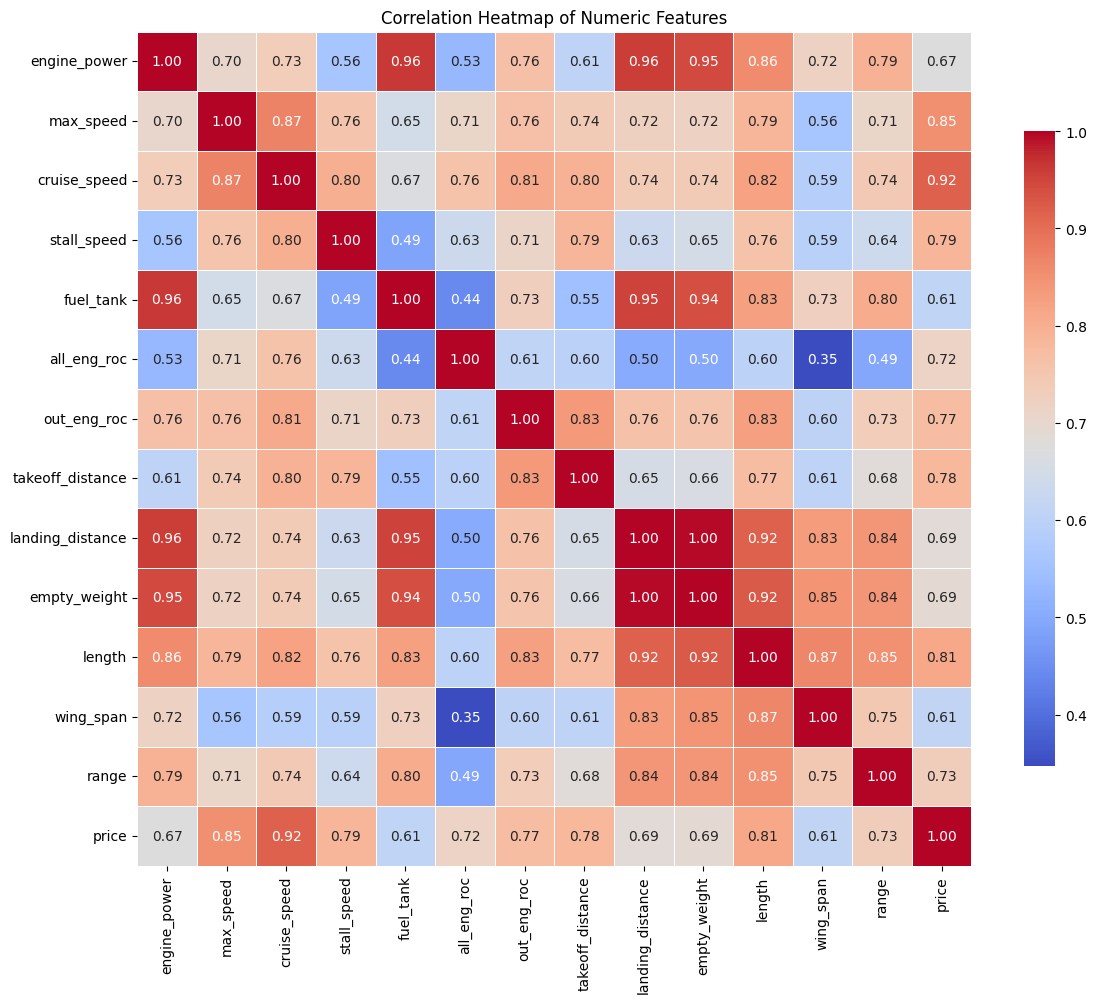

In [199]:
# Seleziona le colonne numeriche
numeric_data = data.select_dtypes(include=[np.number])
if numeric_data.shape[1] >= 4:
    # Calcola la matrice di correlazione
    corr = numeric_data.corr()
    
    # Imposta la figura
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        square=True,
        linewidths=.5,
        cbar_kws={"shrink": .75}
    )
    plt.title('Correlation Heatmap of Numeric Features')
    plt.tight_layout()
    plt.show()
else:
    print('Not enough numeric columns for a meaningful correlation heatmap')

## Controllo il VIF

In [200]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Handle missing or infinite values in the data
numeric_data_cleaned = numeric_data.replace([np.inf, -np.inf], np.nan).dropna()

numeric_data_with_const = sm.add_constant(numeric_data_cleaned)

# Calcola il VIF per ciascuna variabile
vif_data = pd.DataFrame()
vif_data["Regressor"] = numeric_data_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_data_with_const.values, i) for i in range(numeric_data_with_const.shape[1])]

vif_data = vif_data.sort_values("VIF", ascending=False)
print(vif_data)

           Regressor         VIF
9   landing_distance  172.362316
10      empty_weight  133.363446
0              const   94.261829
5          fuel_tank   27.041258
1       engine_power   24.515553
11            length   20.306492
3       cruise_speed   10.601181
14             price    8.626325
12         wing_span    7.253156
7        out_eng_roc    6.518800
2          max_speed    5.301080
8   takeoff_distance    5.244060
13             range    4.653472
4        stall_speed    4.548751
6        all_eng_roc    2.715075


## ho delle variabili con VIF > 10

In [201]:
VIF_THRESHOLD = 10.0

# Copia di lavoro del DB originale
data_pruned = data.copy()

# Considera solo le colonne numeriche (escludendo target, id, …)
numeric_data_cleaned = (
    data_pruned
    .select_dtypes(include=[np.number])
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
)

# Lista di variabili candidate
variables = numeric_data_cleaned.columns.tolist()

# Lista dove accumulare tutte le colonne eliminate
dropped_cols = []

def calculate_vif(df):
    df_with_const = sm.add_constant(df)
    vif = pd.DataFrame({
        "Regressor": df_with_const.columns,
        "VIF": [
            variance_inflation_factor(df_with_const.values, i)
            for i in range(df_with_const.shape[1])
        ]
    })
    return vif.sort_values("VIF", ascending=False)

# Iteriamo finché non scendiamo sotto soglia
while True:
    vif_df = calculate_vif(numeric_data_cleaned[variables])
    vif_no_const = vif_df[vif_df.Regressor != "const"]
    max_vif = vif_no_const["VIF"].max()
    
    if max_vif <= VIF_THRESHOLD:
        print(f"\nTutti i VIF sono sotto {VIF_THRESHOLD:.1f}. Fine.")
        break

    # Colonna da rimuovere
    max_vif_var = vif_no_const.iloc[0]["Regressor"]
    print(f"Rimuovo '{max_vif_var}' con VIF = {max_vif:.1f}")
    
    # 1) aggiungo a dropped_cols
    dropped_cols.append(max_vif_var)
    # 2) la tolgo dalla lista di variabili
    variables.remove(max_vif_var)
    # 3) la elimino da numeric_data_cleaned per i VIF successivi
    numeric_data_cleaned.drop(columns=[max_vif_var], inplace=True)

# Alla fine, dropped_cols contiene tutte le colonne eliminate
print("\nColonne eliminate:", dropped_cols)

# Ora droppale anche da data_pruned (o direttamente da data)
data.drop(columns=dropped_cols, inplace=True)
print("\n\nVariabili finali in data:", data.columns)



Rimuovo 'landing_distance' con VIF = 172.4
Rimuovo 'empty_weight' con VIF = 34.8
Rimuovo 'engine_power' con VIF = 20.1
Rimuovo 'length' con VIF = 16.9
Rimuovo 'cruise_speed' con VIF = 10.4

Tutti i VIF sono sotto 10.0. Fine.

Colonne eliminate: ['landing_distance', 'empty_weight', 'engine_power', 'length', 'cruise_speed']


Variabili finali in data: Index(['model_name', 'engine_type', 'max_speed', 'stall_speed', 'fuel_tank',
       'all_eng_roc', 'out_eng_roc', 'takeoff_distance', 'wing_span', 'range',
       'price'],
      dtype='object')


In [202]:
#VIF finale
vif_final = calculate_vif(numeric_data_cleaned[variables])
print(vif_final)

#numeric_data


          Regressor        VIF
0             const  49.121868
5       out_eng_roc   5.613486
9             price   5.613462
6  takeoff_distance   5.051529
1         max_speed   4.793174
3         fuel_tank   4.667593
8             range   4.385060
2       stall_speed   3.727518
7         wing_span   3.084697
4       all_eng_roc   2.385208


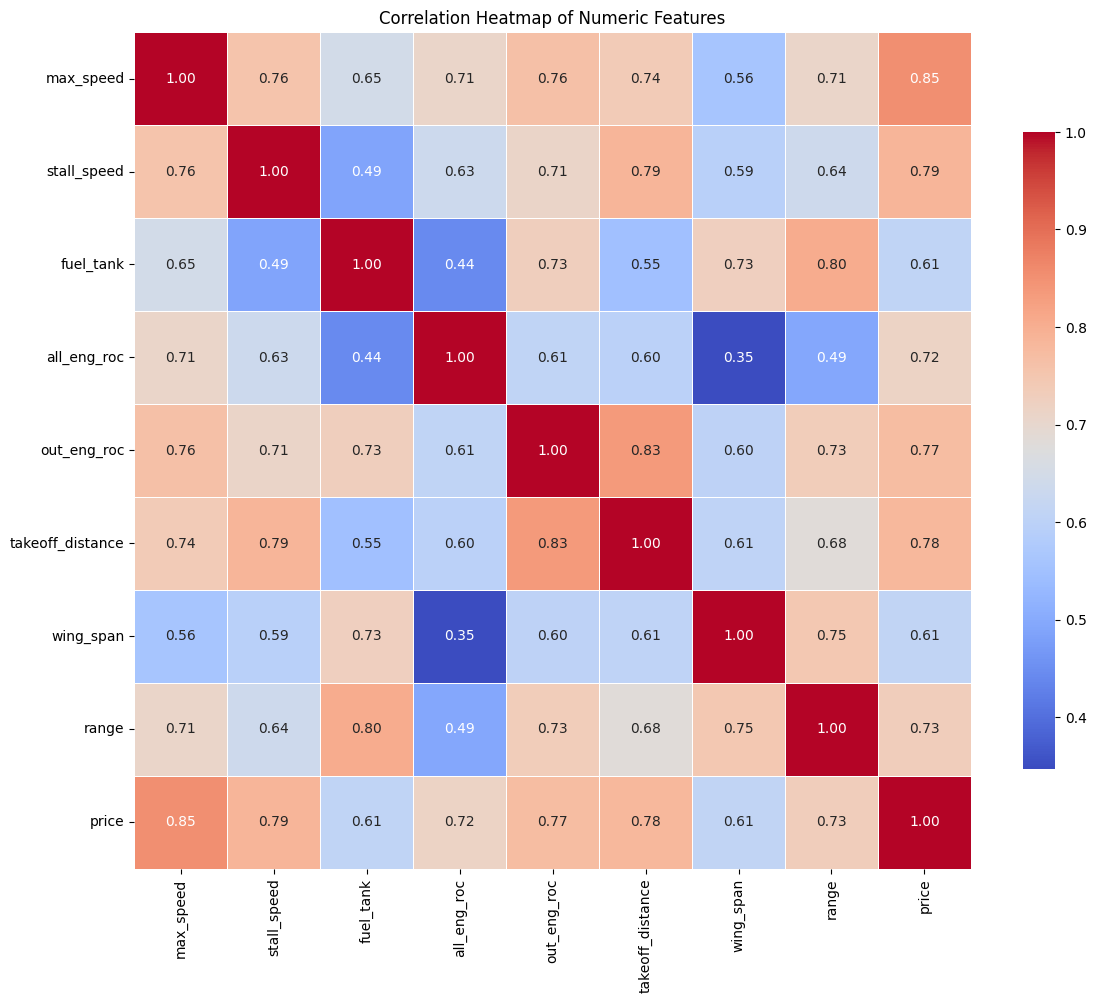

In [203]:
#heatmap    

numeric_data = data.select_dtypes(include=[np.number])


plt.figure(figsize=(12, 10))
sns.heatmap(
    numeric_data.corr(),
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .75}
)
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()


## Divido in due il dataset

In [204]:
data1 = data.copy()
data2 = data.copy()

In [205]:
data2["fuel_efficiency"] = data2["range"] / data2["fuel_tank"]
data2["speed_margin"]    = data2["max_speed"] - data2["stall_speed"]
data2["takeoff_index"]   = data2["out_eng_roc"] / data2["takeoff_distance"]

# 2. Rimuovi le colonne originali
to_drop = [
    "range", "fuel_tank",
    "max_speed", "stall_speed",
    "out_eng_roc", "takeoff_distance"
]
data2 = data2.drop(columns=to_drop)

print(data2.columns)


Index(['model_name', 'engine_type', 'all_eng_roc', 'wing_span', 'price',
       'fuel_efficiency', 'speed_margin', 'takeoff_index'],
      dtype='object')


In [206]:
# Calcola il VIF per ciascuna variabile
vif_data = pd.DataFrame()

# Ensure only numeric columns are used
numeric_data_with_const = sm.add_constant(data2.select_dtypes(include=[np.number]))
#drop price
numeric_data_with_const = numeric_data_with_const.drop(columns=[target])
vif_data["Regressor"] = numeric_data_with_const.columns
vif_data["VIF"] = [
	variance_inflation_factor(numeric_data_with_const.values, i)
	for i in range(numeric_data_with_const.shape[1])
]

vif_data = vif_data.sort_values("VIF", ascending=False)
print(vif_data)

         Regressor        VIF
0            const  68.884483
4     speed_margin   2.421732
1      all_eng_roc   2.031968
3  fuel_efficiency   2.017898
2        wing_span   1.824453
5    takeoff_index   1.094339


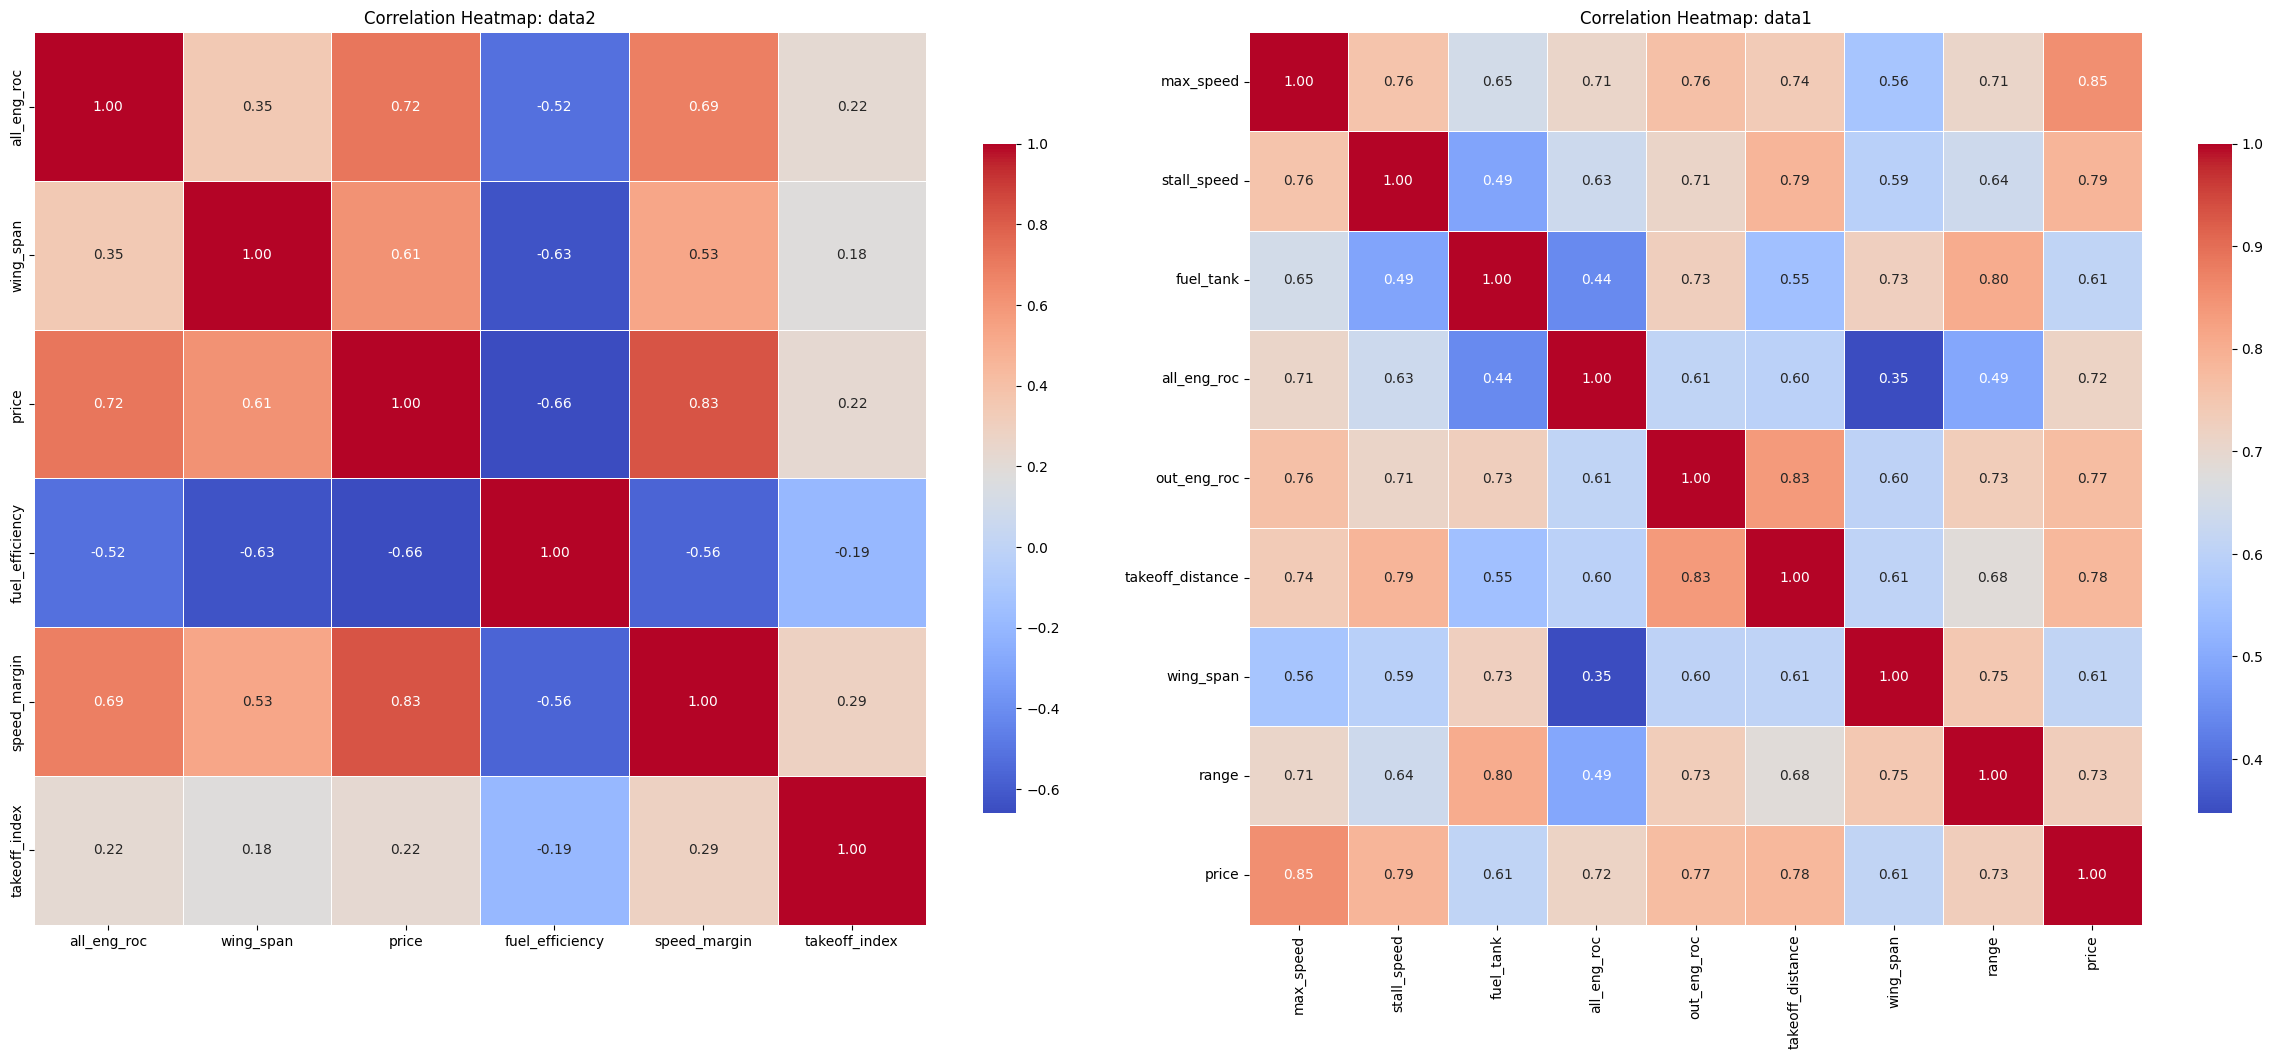

In [207]:

# Selezione solo delle colonne numeriche
numeric_data2 = data2.select_dtypes(include=[np.number])
numeric_data1 = data1.select_dtypes(include=[np.number])

# Calcolo delle correlazioni
corr2 = numeric_data2.corr()
corr1 = numeric_data1.corr()

# Creazione figure affiancata
fig, axes = plt.subplots(1, 2, figsize=(24, 10))  # 1 riga, 2 colonne

# Prima heatmap (data2)
sns.heatmap(
    corr2, ax=axes[0],
    annot=True, fmt='.2f', cmap='coolwarm',
    square=True, linewidths=.5, cbar_kws={"shrink": .75}
)
axes[0].set_title('Correlation Heatmap: data2')

# Seconda heatmap (data1)
sns.heatmap(
    corr1, ax=axes[1],
    annot=True, fmt='.2f', cmap='coolwarm',
    square=True, linewidths=.5, cbar_kws={"shrink": .75}
)
axes[1].set_title('Correlation Heatmap: data1')

# Layout finale
plt.tight_layout()
plt.show()


# Linear Model

In [208]:
numeric_data= data2.select_dtypes(include=[np.number])
numeric_data

,all_eng_roc,wing_span,price,fuel_efficiency,speed_margin,takeoff_index
0,450.0,449.0,1300000.0,10.277778,58.0,0.692308
1,600.0,433.0,1230000.0,12.666667,45.0,0.900000
2,650.0,420.0,1600000.0,11.052632,53.0,0.558824
3,620.0,420.0,1300000.0,11.052632,51.0,0.588235
4,370.0,420.0,1250000.0,12.500000,50.0,0.714124
...,...,...,...,...,...,...
512,3242.0,572.0,4100000.0,0.492014,295.0,0.846491
513,2380.0,572.0,3584000.0,2.979239,223.0,0.749261
514,2236.0,572.0,3200000.0,3.884615,203.0,1.070600
515,1750.0,512.0,3240000.0,3.497382,198.0,1.201962


## Ordering the 3 variables for the more promising

In [209]:
# Target variable

results = []

# Looping every possible variable
for col in numeric_data:
    X = sm.add_constant(data2[[col]])
    y = data2[target]
    
    model = sm.OLS(y, X).fit()
    
    results.append({
        'variable': col,
        'r_squared': model.rsquared,
        'p_value': model.pvalues[col]
    })

# Transforming data frame
results_df = pd.DataFrame(results)

# Ordering
top_r2_pval = results_df.sort_values(by='p_value', ascending=True).head(4)


# Output
print("VARIABILI CON R² PIU' ALTO E p-value PIU BASSO:")
print(top_r2_pval)


VARIABILI CON R² PIU' ALTO E p-value PIU BASSO:
          variable  r_squared        p_value
2            price   1.000000   0.000000e+00
4     speed_margin   0.681646  1.311606e-127
0      all_eng_roc   0.513411   5.039693e-81
3  fuel_efficiency   0.434918   1.373515e-64


### Fit Linear Model: mdev = b0 + b1*speed_margin + e

In [210]:
X = pd.DataFrame({'intercept': np.ones(data2.shape[0]), 'speed_margin': data2['speed_margin']})
X[:4]

,intercept,speed_margin
0,1.0,58.0
1,1.0,45.0
2,1.0,53.0
3,1.0,51.0


In [211]:
y = data2[target]
model = sm.OLS(y, X) #function to fit a simple linear regression. Here we define the model
results = model.fit() #here we fit the model

In [212]:
print(results.summary())

significant_vars = results.pvalues[results.pvalues < 0.05]
print("\nVariabili significative (p-value < 0.05):")
print(significant_vars)

insignificant_vars = results.pvalues[results.pvalues >= 0.05]
print("\nVariabili insignificanti (p-value >= 0.05):")
print(insignificant_vars)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     1081.
Date:                Fri, 25 Apr 2025   Prob (F-statistic):          1.31e-127
Time:                        17:13:38   Log-Likelihood:                -7442.6
No. Observations:                 507   AIC:                         1.489e+04
Df Residuals:                     505   BIC:                         1.490e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept     1.106e+06    4.6e+04     24.056   

### Creating the input matrix using ModelSpec of ISLP package

In [213]:
model = MS(['speed_margin'])
model = model.fit(data2) 
X = model.transform(data2)
X[:4]

,intercept,speed_margin
0,1.0,58.0
1,1.0,45.0
2,1.0,53.0
3,1.0,51.0


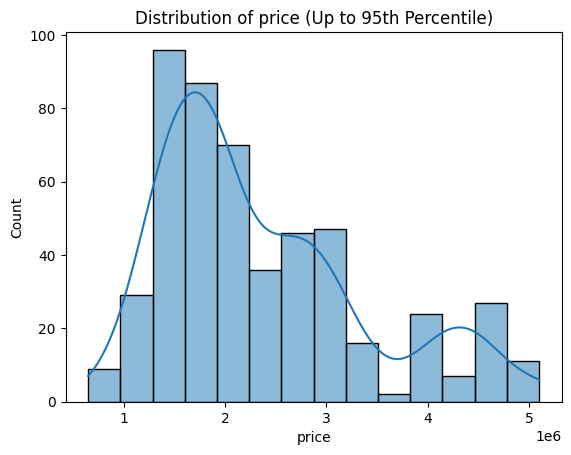

In [214]:
sns.histplot(y, kde=True)

plt.title('Distribution of price (Up to 95th Percentile)')
plt.show()

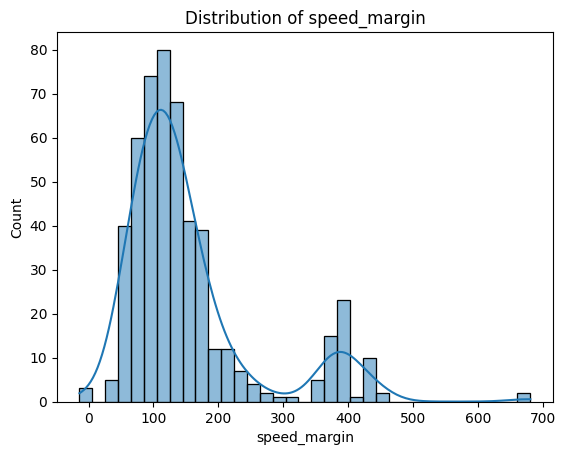

In [215]:
sns.histplot(data2['speed_margin'], kde=True)


plt.title('Distribution of speed_margin')
plt.show()

In [216]:
# Get predictions on new input
new_df = pd.DataFrame({'speed_margin': [70,100,150,200]})
new_X = model.transform(new_df)  # Aggiungi una colonna di 1 per l'intercetta
new_X

,intercept,speed_margin
0,1.0,70
1,1.0,100
2,1.0,150
3,1.0,200


In [217]:
New_X = sm.add_constant(new_df)
new_predictions = results.get_prediction(new_X)
predicted_means = new_predictions.predicted_mean
print(predicted_means)

[1679057.23389213 1924679.35572526 2334049.55878046 2743419.76183566]


In [218]:
#Confidence interval
new_predictions.conf_int(alpha=0.05)

array([[1614337.69506653, 1743776.77271774],
       [1868065.10022523, 1981293.61122528],
       [2283817.31527153, 2384281.80228939],
       [2688303.0094429 , 2798536.51422843]])

In [219]:
intercept = results.params.iloc[0]  # Intercetta (b)
slope = results.params.iloc[1]  # Pendenza (m)

formula = f"y = {slope:.4f} * speed_margin + {intercept:.4f}"

print("FORMULA del modello di regressione:", formula)

FORMULA del modello di regressione: y = 8187.4041 * speed_margin + 1105938.9496


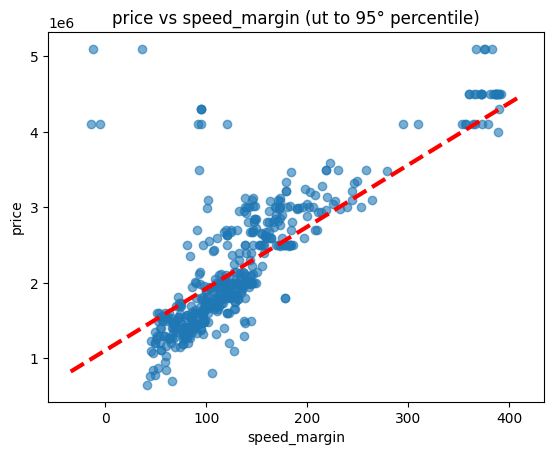

In [220]:
threshold = data2['speed_margin'].quantile(0.95)

filtered_data = data2[data2['speed_margin'] <= threshold]

def abline(ax, b, m, *args, **kwargs):
    "Aggiungi una retta con pendenza m e intercetta b su ax"
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim, ylim, *args, **kwargs)

ax = plt.gca()
ax.scatter(filtered_data['speed_margin'], filtered_data[target], alpha=0.6)

abline(ax, intercept, slope, 'r--', linewidth=3)

plt.title("price vs speed_margin (ut to 95° percentile)")
plt.xlabel("speed_margin")
plt.ylabel("price")
plt.show()

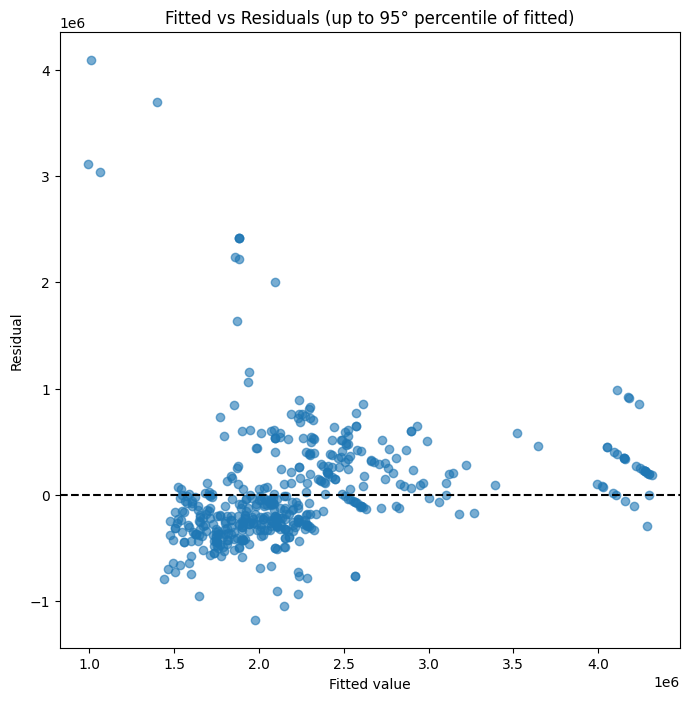

In [221]:
fitted_95 = results.fittedvalues.quantile(0.95)

mask = results.fittedvalues <= fitted_95
fitted_filtered = results.fittedvalues[mask]
resid_filtered = results.resid[mask]

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(fitted_filtered, resid_filtered, alpha=0.6)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--')
ax.set_title("Fitted vs Residuals (up to 95° percentile of fitted)")
plt.show()

180

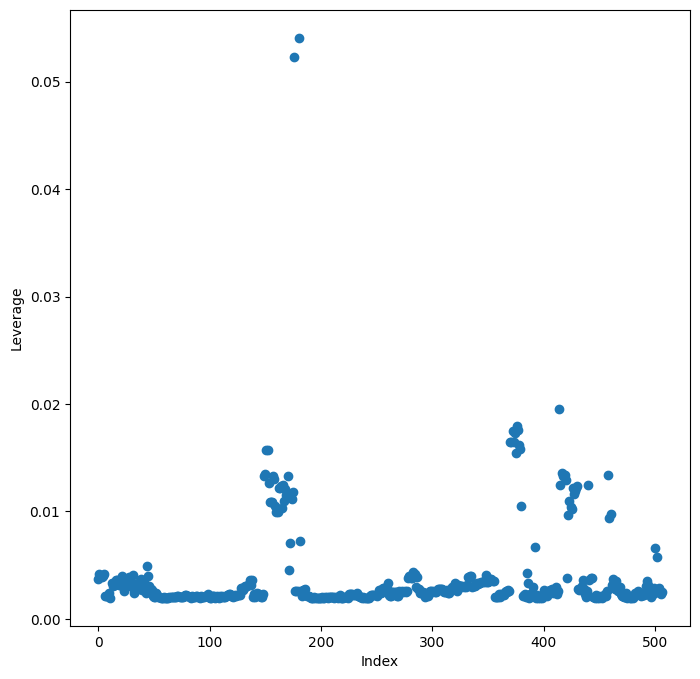

In [222]:
# Compute leverage statistics
infl = results.get_influence()
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
np.argmax(infl.hat_matrix_diag)

## commentare

# Multiple Linear Regression

In [223]:
# y = b*X + e (perform a regression using all of the predictors)
numeric_data = data2.select_dtypes(include=[np.number])
terms = numeric_data.drop(columns=[target])
print(terms.columns)

Index(['all_eng_roc', 'wing_span', 'fuel_efficiency', 'speed_margin',
       'takeoff_index'],
      dtype='object')


In [224]:
X = MS(terms).fit_transform(data2)
model = sm.OLS(y, X)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,822300.0000,177000.000,4.647,0.000
all_eng_roc,176.7117,20.856,8.473,0.000
wing_span,1789.6683,281.263,6.363,0.000
fuel_efficiency,-27880.0000,5517.995,-5.053,0.000
speed_margin,4766.3856,323.252,14.745,0.000
takeoff_index,-104600.0000,72300.000,-1.446,0.149


In [225]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     355.6
Date:                Fri, 25 Apr 2025   Prob (F-statistic):          3.18e-162
Time:                        17:13:39   Log-Likelihood:                -7348.7
No. Observations:                 507   AIC:                         1.471e+04
Df Residuals:                     501   BIC:                         1.473e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept        8.223e+05   1.77e+05     

In [226]:
significant_vars = results.pvalues[results.pvalues < 0.05]
print("\nVariabili significative (p-value < 0.05):")
print(significant_vars)

insignificant_vars = results.pvalues[results.pvalues >= 0.05]
print("\nVariabili insignificanti (p-value >= 0.05):")
print(insignificant_vars)


Variabili significative (p-value < 0.05):
intercept          4.302172e-06
all_eng_roc        2.677362e-16
wing_span          4.469711e-10
fuel_efficiency    6.096768e-07
speed_margin       3.945608e-41
dtype: float64

Variabili insignificanti (p-value >= 0.05):
takeoff_index    0.148737
dtype: float64


In [227]:
# getting goodness of fit
print("R2", results.rsquared)
print("RSE", np.sqrt(results.scale))

R2 0.7801840706033354
RSE 480004.8980394255


In [228]:
#VIF su regressione lineare multipla su X
X = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data["Regressor"] = X.columns
vif_data["VIF"] = [VIF(X.values, i) for i in range(X.shape[1])]
vif_data = vif_data.sort_values("VIF", ascending=False)
print(vif_data)

         Regressor        VIF
0        intercept  68.884483
4     speed_margin   2.421732
1      all_eng_roc   2.031968
3  fuel_efficiency   2.017898
2        wing_span   1.824453
5    takeoff_index   1.094339


## Non-Linear Transformations of the Predictor Variables

In [229]:
# poly() function present in the package ISLP specifies that columns representing polynomial functions of its first argument are added to the model matrix
X = MS([poly('wing_span', degree=2), 'takeoff_index']).fit_transform(data2)
model = sm.OLS(y, X)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,1822000.0,139000.0,13.089,0.0
"poly(wing_span, degree=2)[0]",13430000.0,794000.0,16.917,0.0
"poly(wing_span, degree=2)[1]",-4001000.0,786000.0,-5.089,0.0
takeoff_index,461300.0,115000.0,4.006,0.0


In [230]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     119.9
Date:                Fri, 25 Apr 2025   Prob (F-statistic):           1.35e-58
Time:                        17:13:39   Log-Likelihood:                -7596.0
No. Observations:                 507   AIC:                         1.520e+04
Df Residuals:                     503   BIC:                         1.522e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
intercept       

## Qualitative predictors
Based on the Carseats dataset present in the package ISLP, will attempt to predict Sales (child car seat sales) in 400 locations based
on a number of predictors.

The Carseats data includes the qualitative predictor "ShelveLoc," which indicates the quality of the shelving location with three possible values: Bad, Medium, and Good.

In general for qualitative predictor the ModelSpec() generates one-hot encoding of the categorical variables automatically

In [231]:
Carseats = load_data('Carseats')
Carseats.columns

Index(['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price',
       'ShelveLoc', 'Age', 'Education', 'Urban', 'US'],
      dtype='object')

In [232]:
allvars = list(Carseats.columns.drop('Sales'))
y = Carseats['Sales']
final = allvars + [('Income', 'Advertising'),
('Price', 'Age')]
X = MS(final).fit_transform(Carseats)
model = sm.OLS(y, X)
summarize(model.fit())

,coef,std err,t,P>|t|
intercept,6.5756,1.009,6.519,0.000
CompPrice,0.0929,0.004,22.567,0.000
Income,0.0109,0.003,4.183,0.000
Advertising,0.0702,0.023,3.107,0.002
Population,0.0002,0.000,0.433,0.665
Price,-0.1008,0.007,-13.549,0.000
ShelveLoc[Good],4.8487,0.153,31.724,0.000
ShelveLoc[Medium],1.9533,0.126,15.531,0.000
Age,-0.0579,0.016,-3.633,0.000
Education,-0.0209,0.020,-1.063,0.288


# Cross Validation

### Validation set approach

In [233]:
from functools import partial
from sklearn.model_selection import (cross_validate ,KFold ,ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm #a wrapper that enables us to easily use the cross-validation tools of sklearn with models fit by statsmodels
from sklearn.model_selection import train_test_split

In [234]:
data_train, data_test = train_test_split(data2, test_size=0.2, random_state=42)
# random_state is needed for reproducible result across run

In [235]:
# Fit a linear regression model
from ISLP.models import ModelSpec as MS
import statsmodels.api as sm

# Ensure all required variables are defined
terms = data2.select_dtypes(include=[np.number]).drop(columns=[target])
X = MS(terms.columns.tolist()).fit_transform(data2)
X_train = MS(terms.columns.tolist()).fit_transform(data_train)
X_test = MS(terms.columns.tolist()).fit_transform(data_test)
y_train = data_train[target]
y_test = data_test[target]

# Fit the model
model = sm.OLS(y_train, X_train)
results = model.fit()

# Print the summary
print(results.summary())



                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     283.2
Date:                Fri, 25 Apr 2025   Prob (F-statistic):          8.34e-129
Time:                        17:13:39   Log-Likelihood:                -5875.3
No. Observations:                 405   AIC:                         1.176e+04
Df Residuals:                     399   BIC:                         1.179e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept        8.339e+05   2.07e+05     

In [236]:
# Predict on the test set
y_pred = results.predict(X_test)
# Calculate R-squared
r_squared = results.rsquared
print(f"R-squared on test set: {r_squared:.4f}")

R-squared on test set: 0.7802


## Leave One-out Cross validation
The sklearn_sm() class takes a statsmodels model as its first argument. It also accepts two optional arguments: model_str for specifying a formula, and model_args, which is a dictionary containing additional arguments for fitting the model.

In [237]:
hp_model = sklearn_sm(sm.OLS, MS(['horsepower']))
X, Y = Auto.drop(columns=['mpg']), Auto['mpg']

# This is a LOOCV because cv use the number of sample in our dataset, that is Auto.shape[0], making sure that each sample is use as a test set
cv_results = cross_validate(hp_model ,X, Y, cv=Auto.shape[0])
cv_err = np.mean(cv_results['test_score'])
cv_err

NameError: name 'Auto' is not defined

## K-Fold cross validation

In [ ]:
hp_model = sklearn_sm(sm.OLS, MS(['horsepower']))
X, Y = Auto.drop(columns=['mpg']), Auto['mpg']
kf = KFold(n_splits=10, shuffle=True, random_state=1)
cv_results = cross_validate(hp_model, X, Y, cv=kf)
cv_err = np.mean(cv_results['test_score'])
cv_err

## Modello di Regressione Lineare Multipla ottenuto con Stepwise

In [ ]:
import numpy as np
import pandas as pd
from matplotlib .pyplot import subplots
from statsmodels .api import OLS
import sklearn. model_selection as skm
import sklearn. linear_model as skl
from sklearn. preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
from sklearn. pipeline import Pipeline
from sklearn. decomposition import PCA
from sklearn. cross_decomposition import PLSRegression
from ISLP.models import \
(Stepwise ,
sklearn_selected ,
sklearn_selection_path )

import l0bnb

In [ ]:
data.info()

In [ ]:
data=data.dropna()
data.shape
data.info()

We first choose the best model using forward selection based on Cp (6.2).
This score is not built in as a metric to sklearn. We therefore define a
function to compute it ourselves, and use it as a scorer. By default, sklearn
tries to maximize a score, hence our scoring function computes the negative
Cp statistic.

In [ ]:
def nCp(sigma2 , estimator , X, Y):
    # Calcola il numero di parametri stimati
    n, p = X.shape
    Yhat = estimator .predict(X)
    RSS = np.sum ((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n

In [ ]:
# Exclude non-numeric columns
numeric_columns = data.select_dtypes(include=[np.number]).columns.drop('price')
design = MS(numeric_columns).fit(data)

# Prepare the target and feature matrices
Y = np.array(data['price'])
X = design.transform(data)

# Fit the OLS model
sigma2 = OLS(Y, X).fit()

In [ ]:
neg_Cp = partial(nCp , sigma2)

In [ ]:
strategy = Stepwise . first_peak (design ,
direction ='forward ',
max_terms =len(design.terms))

In [ ]:
data_MSE = sklearn_selected (OLS ,
strategy )
data_MSE .fit(data ,Y)
data_MSE . selected_state_

In [ ]:
# Ensure sigma2 is a numeric value (variance of residuals)
sigma2_value = sigma2.mse_resid  # Extract the mean squared error of residuals from the model

# Redefine neg_Cp with the correct sigma2 value
neg_Cp = partial(nCp, sigma2_value)

# Use the corrected neg_Cp in the sklearn_selected function
data_Cp = sklearn_selected(OLS, strategy, scoring=neg_Cp)
data_Cp.fit(data, Y)
data_Cp.selected_state_

In [ ]:
# Elenco dei predittori
selected = list(data_Cp.selected_state_)

# Matrice X con costante
X_best = sm.add_constant(data[selected])

# Risposta
y = data['price']

# Fit OLS
model_best = sm.OLS(y, X_best).fit()

# Sommario completo
print(model_best.summary())


In [ ]:
#VIF
vif_data = pd.DataFrame()
vif_data["Regressor"] = X_best.columns
vif_data["VIF"] = [VIF(X_best.values, i) for i in range(X_best.shape[1])]
vif_data = vif_data.sort_values("VIF", ascending=False)
print(vif_data)


**Commento**

Il modello selezionato tramite stepwise forward selection con criterio di Mallows Cp mostra buone capacità esplicative (R² = 0.883), identificando variabili fortemente associate al prezzo degli aeromobili. Tuttavia, la presenza di multicollinearità in alcune covariate suggerisce cautela nell’interpretazione individuale dei coefficienti. In applicazioni pratiche, potrebbe essere utile considerare anche tecniche alternative come la regressione Ridge o Lasso per migliorare la stabilità del modello e gestire meglio la collinearità. La validazione incrociata e l'analisi dei residui sono essenziali per confermare l'affidabilità del modello in contesti reali.

In [ ]:
# Definizione della funzione per il Cp negativo
def nCp(sigma2, estimator, X, Y):
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat) ** 2)
    return -(RSS + 2 * p * sigma2) / n

# Preparazione dei dati a partire da data2
# (assicurati che data2 sia già caricato e pulito)
numeric_cols = data2.select_dtypes(include=[np.number]).columns.drop('price')
design2 = MS(numeric_cols).fit(data2)

Y2 = np.array(data2['price'])
X2 = design2.transform(data2)

# Stima di sigma2 tramite OLS
sigma2_mod = OLS(Y2, X2).fit()
sigma2_val = sigma2_mod.mse_resid

# Scorer per Cp
neg_Cp = partial(nCp, sigma2_val)

# Strategia stepwise forward basata su Mallows Cp
strategy2 = Stepwise.first_peak(
    design2,
    direction='forward',
    max_terms=len(design2.terms)
)

# Selezione del modello
model2_Cp = sklearn_selected(OLS, strategy2, scoring=neg_Cp)
model2_Cp.fit(data2, Y2)

# Variabili selezionate
print("Variabili selezionate:", model2_Cp.selected_state_)


In [ ]:
#Elenco predittori
selected2 = list(model2_Cp.selected_state_)
# Matrice X con costante
X_best2 = sm.add_constant(data2[selected2])
# Risposta
y2 = data2['price']
# Fit OLS
model_best2 = sm.OLS(y2, X_best2).fit()
# Sommario completo
print(model_best2.summary())

In [ ]:
#VIF
vif_data = pd.DataFrame()
vif_data["Regressor"] = X_best2.columns
vif_data["VIF"] = [VIF(X_best2.values, i) for i in range(X_best2.shape[1])]
vif_data = vif_data.sort_values("VIF", ascending=False)
print(vif_data)


## Choosing Among Models Using the Validation Set Approach and Cross-Validation

In [ ]:
# 1) Definisci design e risposta
# ————————————————
numeric_cols = data2.select_dtypes(include=[np.number]).columns.drop('price')
design2      = MS(numeric_cols).fit(data2)
Y2           = data2['price'].values

# ————————————————
# 2) Costruisci il full forward‐selection path
# ————————————————
strategy2 = Stepwise.fixed_steps(
    design2,
    max_terms = len(design2.terms),
    direction = 'forward'
)
full_path2 = sklearn_selection_path(OLS, strategy2)
